In [1]:
import sys
sys.path.append("..")
from model_analysis.jnk3_no_ask1 import model
import numpy as np
from pysb.simulator import ScipyOdeSimulator
import matplotlib.pyplot as plt
from model_analysis.equilibration_function import pre_equilibration
import sympy
from collections import OrderedDict
import pandas as pd

In [2]:
# Loading fitted parameters

idx_pars_calibrate = [1, 5, 9, 11, 15, 17, 19, 23, 25, 27, 31, 35, 36, 37, 38, 39, 41, 43] #pydream3
rates_of_interest_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]

calibrated_pars = np.load('../model_analysis/most_likely_par_500000_4box.npy')
# calibrated_pars = np.load('calibrated_pars_pso1.npy') # most likely parameter from pydream calibration
param_values = np.array([p.value for p in model.parameters])

jnk3_initial_idxs = [47, 48, 49]
arrestin_idx = 44
kcat_idx = [36, 37]

par_set_calibrated = np.copy(param_values)
par_set_calibrated[rates_of_interest_mask] = 10 ** calibrated_pars

In [3]:
def plot_arrestin_noarrestin_ppjnk3():
    """
    Plot ppJNK3 activation with and withou arrestin
    Returns
    -------

    """
    # Pre-equilibration
    exp_data = pd.read_csv('../data/exp_data_3min.csv')
    tspan = np.linspace(0, exp_data['Time (secs)'].values[-1], 181)
    solver = ScipyOdeSimulator(model, tspan=tspan)

    pars_arr = np.copy(par_set_calibrated)
    pars_noarr = np.copy(par_set_calibrated)

    # Pre-equilibration
    time_eq = np.linspace(0, 100, 100)
    pars_arr_eq = np.copy(par_set_calibrated)
    pars_noarr_eq = np.copy(par_set_calibrated)

    pars_noarr_eq[arrestin_idx] = 0
    pars_noarr_eq[jnk3_initial_idxs] = [0.5958, 0, 0.0042]

    all_pars = np.stack((pars_arr_eq, pars_noarr_eq))
    all_pars[:, kcat_idx] = 0  # Setting catalytic reactions to zero for pre-equilibration
    eq_conc = pre_equilibration(model, time_eq, all_pars)[1]

    # Simulating models with initials from pre-equilibration and parameters for condition with/without arrestin
    sim = solver.run(param_values=[pars_arr, pars_noarr], initials=eq_conc).all

    print ((sim[0]['all_jnk3'][-1] ) / (sim[1]['all_jnk3'][-1] ))
    print (sim[0]['all_jnk3'][-1] , sim[1]['all_jnk3'][-1] )

    plt.plot(tspan, sim[0]['all_jnk3'], color='r', label='ppJNK3 with Arrestin-3')
    plt.plot(tspan, sim[1]['all_jnk3'], color='k', label='ppJNK3 no Arrestin-3')
    plt.xlabel('Time (s)')
    plt.ylabel(r' Normalized Concentration')
    plt.legend()
#     plt.savefig('arrestin_noarrestin_ppjnk3.pdf', format='pdf', bbox_inches='tight')

1.7559912864382718
0.5882709365314808 0.3350078904575249


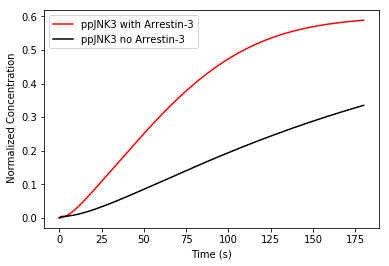

In [4]:
plot_arrestin_noarrestin_ppjnk3()